# 학습과 테스트


In [3]:
# 데이터 BigQuery에 저장
# !bq load --autodetect testdataset.wdbc ./gcpml-freelec/datasets/wdbc.csv

Upload complete.
Waiting on bqjob_r79196a36968aea95_00000166ba9b41e2_1 ... (0s) Current status: DONE   


In [1]:
import pandas as pd

query = 'select * from testdataset.wdbc order by index'
dataset = pd.read_gbq(project_id = 'mlwithgcp', query = query)

dataset.head()

Requesting query... ok.
Job ID: 042aee76-8e3f-4d78-9a6a-90f32d87dbcd
Query running...
Query done.
Processed: 139.5 KB Billed: 10.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 569 rows.

Total time taken 2.76 s.
Finished at 2018-10-28 22:56:41.


,index,diagnostic,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,8670,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,...,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,8915,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,...,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,9047,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,...,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,85715,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,...,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


 - 위 데이터는 유방암 진단 데이터로, '악성(Malignant)', 또는 '양성(Benign)' 레이블이 달려 있음 - 2-class classification
 - 위 데이터는 'UC Urvine'의 머신러닝 샘플 데이터 리포지터리에서 받을 수 있음

___
> ## 데이터 가공하기

- 문자 레이블을 숫자로 변경하기 전까지는 데이터를 100% 활용하기 어려움
- 'diagnostic'열은 (0,1)로 변경하고, 'index'열은 불필요하므로 삭제

In [3]:
dataset['diagnostic'] = dataset['diagnostic'].apply(lambda X: 0 if X=='M' else 1)

In [4]:
dataset.drop('index', axis = 1, inplace = True)

In [5]:
dataset.head()

,diagnostic,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,0,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,1,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,1,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,...,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,1,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,...,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,0,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,...,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


- scikit-learn은 DataFrame과 호환되지만, 여러 유틸 사용에 문제가 발생 할 수 있으므로 array로 통일하여 사용(`as_matrix()`)

In [11]:
X_dataset = dataset.drop('diagnostic', axis = 1).as_matrix()
y_dataset = dataset['diagnostic'].as_matrix()

___
> ## 학습데이터와 테스트데이터 분리하기

- `sklearn.model_selection`에는 `train_test_split()`이라는 함수로 학습데이터와 테스트데이터를 분리하는 좋은 기능이 있음
- 20% 크기로 아래와 같이 분리 가능

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset,
                                                   test_size = 0.2, 
                                                   random_state = 42)

- 학습은 이전과 마찬가지로 `fit`을 사용
- 추가로 테스트데이터로 검증할 수 있는 `score`기능으로 정답률 확인

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
classifier = RandomForestClassifier(random_state = 42)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.9298245614035088

- 약 93.0%의 정답률을 보임
- RandomForest 대신 SVM을 사용하면 다음과 같은 결과를 확인할 수 있음

In [17]:
from sklearn.svm import SVC

In [18]:
classifier = SVC()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.5964912280701754

- 약 59.6%의 정답률로 썩 성능이 좋지 않음
- 이는 특징량 범위 차이의 영향일 가능성이 큼
- 예를 들어, `mean_area`는 1000을 넘는 값이 있지만, `mean_smoothness`는 1보다 작은 값들로 구성
- 따라서 **정규화**과정이 필요  
    *SVM이나 로지스틱은 판별식으로 식별경계를 만들기에 정규화가 필요하나, RandomForest는 하나의 특징량에 대해 값이 큰지 작은지 질문을 반복하기 떄문에 정규화 과정이 불필요*
    
    
- 정규화는 `sklearn.preprocessing` 모듈 내 `MinMaxScaler`를 사용하여 수행
- `MinMaxScaler().fit_transform`을 사용하여 0-1 범위로 정규화

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.956140350877193

- 정규화 후 SVM의 정답률은 95.6%로 RandomForest와 유사한 정답률을 보임

___
> ## K-Fold 크로스 밸리데이션

- 데이터세트를 분할하는 방법 중 'K-Fold'라는 방법이 있음
- 이는 데이터를 K개로 분할하여 그 중 하나를 테스트로, 나머지를 학습데이터롤 사용하되, K번 반복하는 과정임
- 이를 통해 데이터 편향을 최소화 시키며 최선의 학습 모델을 찾을 확률을 높이는 과정으로 볼 수 있음
- K-Fold는 `sklearn.model_selection` 모듈의 `KFold`를 사용 (`train_index, test_index = KFold(.....).split(데이터)`)
- 4-Fold의 경우 아래와 같이 학습 가능


In [26]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


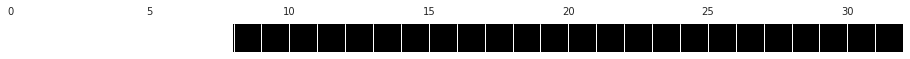

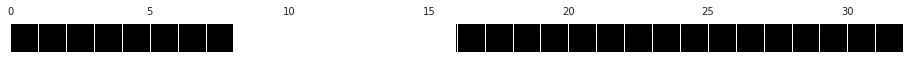

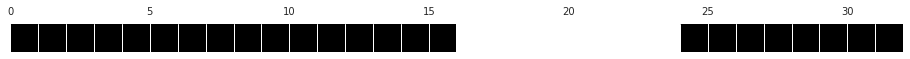

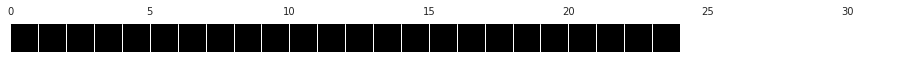

In [28]:
# 데이터 4분할
kf = KFold(n_splits = 4, random_state = 42, shuffle = False)
test_data = np.zeros(32)

# 학습전용과 테스트 전용으로 분할된 배열의 인덱스 추출
for train_index, test_index in kf.split(test_data):
  # test_index에 해당하는 인덱스만 1로 만들고, 나머지는 0으로 지정
  dat = np.zeros(32)
  dat[test_index] = 1
  
  plt.gray()
  plt.matshow(dat.reshape(1,32), extent = [0, 32, 0, 1])
  plt.gca().set_yticks([])
  plt.gca().set_xticks(range(32), minor = 'ture')
  plt.grid(which='minor')
  plt.show()

- 위의 경우 `KFold`에서 `shuffle = False`로 지정하였기 때문에 순차적으로 분류되었음을 확인가능함
- `shuffle = True`로 지정하면 아래와 같은 결과값 반환

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


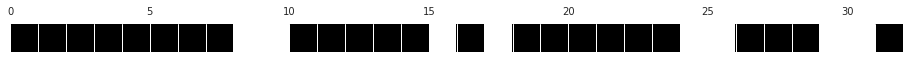

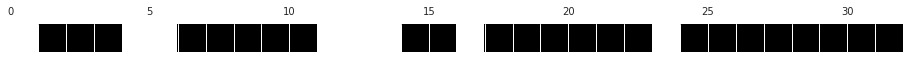

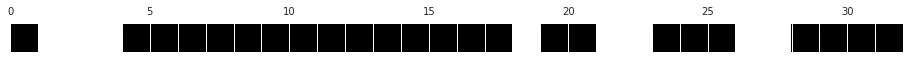

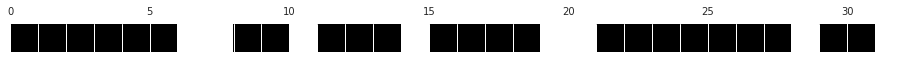

In [29]:
# 데이터 4분할
kf = KFold(n_splits = 4, random_state = 42, shuffle = True)
test_data = np.zeros(32)

# 학습전용과 테스트 전용으로 분할된 배열의 인덱스 추출
for train_index, test_index in kf.split(test_data):
  # test_index에 해당하는 인덱스만 1로 만들고, 나머지는 0으로 지정
  dat = np.zeros(32)
  dat[test_index] = 1
  
  plt.gray()
  plt.matshow(dat.reshape(1,32), extent = [0, 32, 0, 1])
  plt.gca().set_yticks([])
  plt.gca().set_xticks(range(32), minor = 'ture')
  plt.grid(which='minor')
  plt.show()

- 데이터 분할 외 SVM을 CV하여 정답률을 구하는 과정은 아래와 같이 구현

In [34]:
classifier = SVC()

kf = KFold(n_splits = 4, random_state = 42, shuffle = True)
for train_index, test_index in kf.split(X_dataset):
  # 데이터 구분
  X_train, X_test = X_dataset[train_index], X_dataset[test_index]
  y_train, y_test = y_dataset[train_index], y_dataset[test_index]
  
  # 정규화
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  
  # 학습 및 정답률 반환
  classifier.fit(X_train, y_train)
  print(classifier.score(X_test, y_test))

0.958041958041958
0.9436619718309859
0.971830985915493
0.9577464788732394


- 이전 정답률과 큰 차이를 보이지는 않으며, 낮은 경우에도 94.4%로 학습기와 매개변수가 적당하게 설정되어 있다는 것을 알 수 있음
- 만약 어떤 하나가 85%(혹은 under)가 나왔다면 문제가 발생했다는 의미로, 식별기의 매개변수를 조정할 필요가 있음